In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = InteractiveSession(config = config)

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
import pandas as pd 
import numpy as np
from keras.preprocessing.image import * 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import random
import os 

path = 'datasets/'

# 데이터 형상 관련 상수 정의 
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL=3

# 학습 데이터 준비 
filenames = os.listdir(path)

categories=[]
for filename in filenames:
    category=filename.split("_")[0]
    if category =="knot":
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame(
    {"filename":filenames,
    "category":categories})        
df

filename  category
0        knot_8639.png         1
1      branch_7786.png         0
2      leaves_7169.png         0
3        knot_1988.png         1
4     branch_21291.png         0
...                ...       ...
1714    knot_17368.png         1
1715    knot_11460.png         1
1716    knot_11648.png         1
1717    root_15011.png         0
1718    knot_19229.png         1

[1719 rows x 2 columns]

<IPython.core.display.Javascript object>


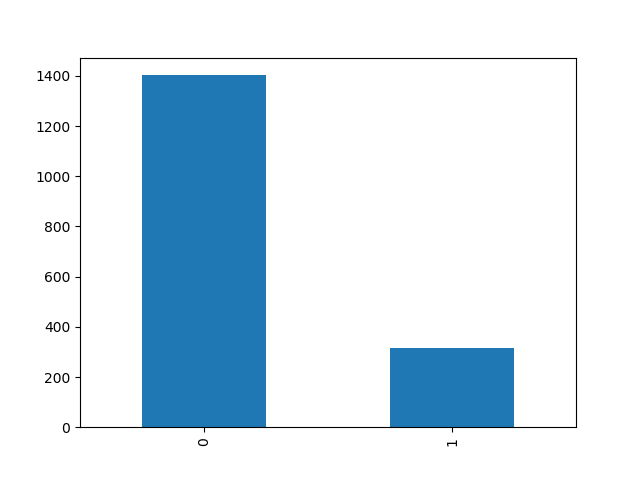

In [6]:
%matplotlib notebook
df['category'].value_counts().plot.bar()

<IPython.core.display.Javascript object>


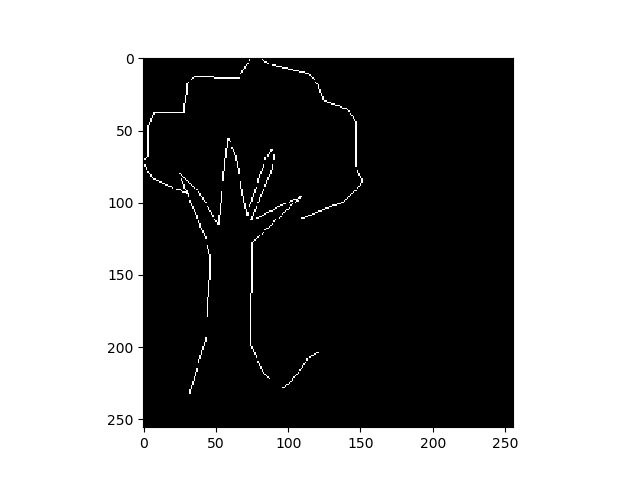

In [7]:
%matplotlib notebook
sample = random.choice(filenames)
image = load_img(path+sample)
plt.imshow(image)

In [8]:
from keras.models import Sequential
from keras.layers import * 

model = Sequential()
model.add(Conv2D(128, (3,3), activation="relu", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH , IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 레이어 2 
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 레이어3
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


# 레이어4
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
          
# Fully Connected 
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))


model.add(Dense(2,activation="sigmoid"))

In [9]:
# 모델 실행 옵션 
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 128)     3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=50)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_accuracy", 
                        patience = 2, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)
                        
callbacks = [earlystop, learning_rate_reduction]

In [11]:
# 이미지 제너레이터에서 class_mode = "categorical"로 지정하기 위해 컬럼 카테고리를 스트링으로 변경함. 
df['category']=df['category'].replace({0:'elses',1:"knot"})

In [12]:
train_df, data_df = train_test_split(df , test_size=0.2, random_state= 42)

train_df=train_df.reset_index(drop=True)
data_df=data_df.reset_index(drop=True)

In [13]:
train_df['category'].value_counts()

elses    1117
knot      258
Name: category, dtype: int64

In [14]:
data_df['category'].value_counts()


elses    286
knot      58
Name: category, dtype: int64

In [15]:
test_df, valid_df = train_test_split(data_df , test_size=0.2, random_state= 42)

test_df=test_df.reset_index(drop=True)
valid_df=valid_df.reset_index(drop=True)

In [16]:
test_df['category'].value_counts()

elses    229
knot      46
Name: category, dtype: int64

In [17]:
valid_df['category'].value_counts()

elses    57
knot     12
Name: category, dtype: int64

In [18]:
total_train=train_df.shape[0]
total_validate=valid_df.shape[0]
batch_size=16

# 트레이닝 데이터의 제너레이터 설정 
train_datagen=ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1, 
        height_shift_range=0.1)
        
train_generator=train_datagen.flow_from_dataframe(
    train_df, 
    path,
    x_col = "filename", 
    y_col = "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size )
    
validate_datagen=ImageDataGenerator(rescale=1./255)

validation_generator=validate_datagen.flow_from_dataframe(
    valid_df,
    path,
    x_col= "filename",
    y_col= "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size )

test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(
    test_df,
    path,
    x_col= "filename",
    y_col= "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size )





Found 1375 validated image filenames belonging to 2 classes.
Found 69 validated image filenames belonging to 2 classes.
Found 275 validated image filenames belonging to 2 classes.


In [19]:
example_df=train_df.sample(n=1).reset_index(drop=True)
example_df

filename category
0  leaves_18593.png    elses

In [20]:
example_generator = train_datagen.flow_from_dataframe(
                    example_df,
                    path,
                    x_col = "filename",
                    y_col = "category",
                    target_size = IMAGE_SIZE,
                    class_mode = "categorical")

Found 1 validated image filenames belonging to 1 classes.


<IPython.core.display.Javascript object>


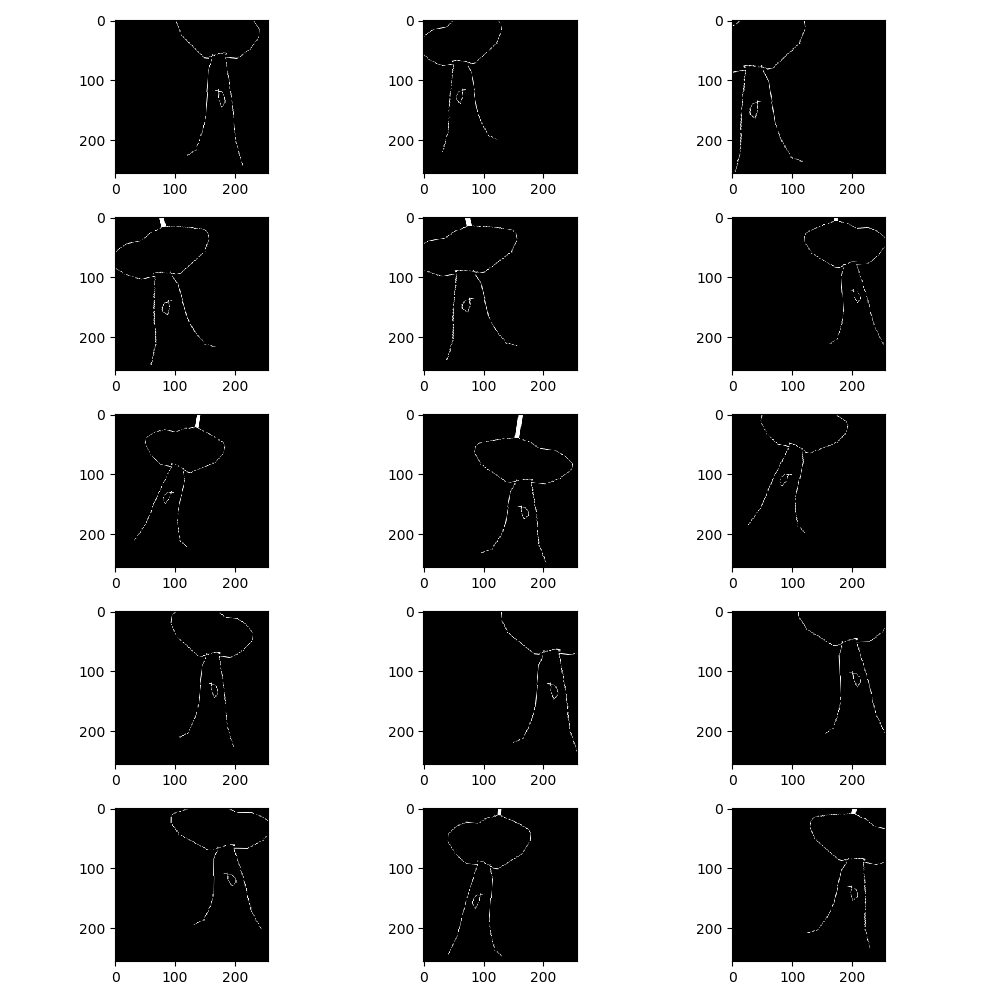

In [21]:
plt.figure(figsize=(10,10))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for xBatch, yBatch in example_generator:
        image = xBatch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [22]:
epochs = 100

history = model.fit(
    train_generator, 
    epochs = epochs, 
    validation_data=  validation_generator,
    callbacks = callbacks)


Epoch 1/100
86/86 [==============================] - 29s 277ms/step - loss: 0.6818 - accuracy: 0.6724 - val_loss: 0.4597 - val_accuracy: 0.8261
Epoch 2/100
86/86 [==============================] - 21s 247ms/step - loss: 0.4661 - accuracy: 0.8049 - val_loss: 0.4532 - val_accuracy: 0.8261
Epoch 3/100
86/86 [==============================] - 22s 251ms/step - loss: 0.4711 - accuracy: 0.7950 - val_loss: 0.5164 - val_accuracy: 0.8261

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/100
86/86 [==============================] - 21s 246ms/step - loss: 0.4176 - accuracy: 0.8068 - val_loss: 0.4686 - val_accuracy: 0.8261
Epoch 5/100
86/86 [==============================] - 21s 244ms/step - loss: 0.4425 - accuracy: 0.8113 - val_loss: 0.5681 - val_accuracy: 0.6667

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/100
86/86 [==============================] - 22s 251ms/step - loss: 0.4590 - accuracy: 0.7871 - val_loss: 0.57

In [24]:
model.save('knot.h5')

In [25]:
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

<IPython.core.display.Javascript object>


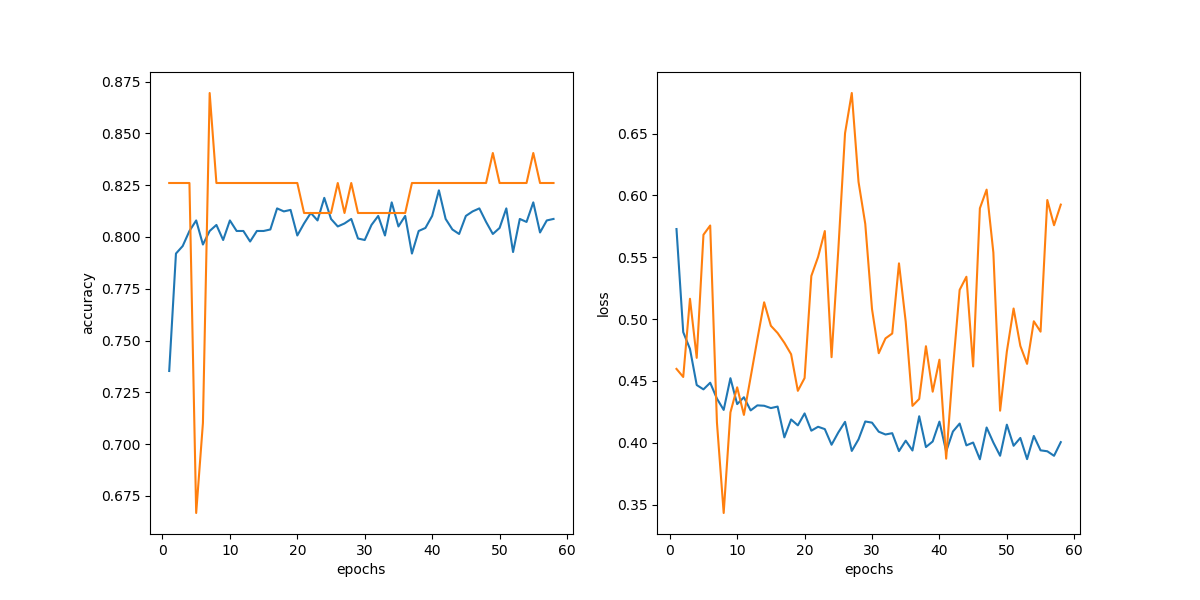

In [26]:
plot_history(history)

<IPython.core.display.Javascript object>


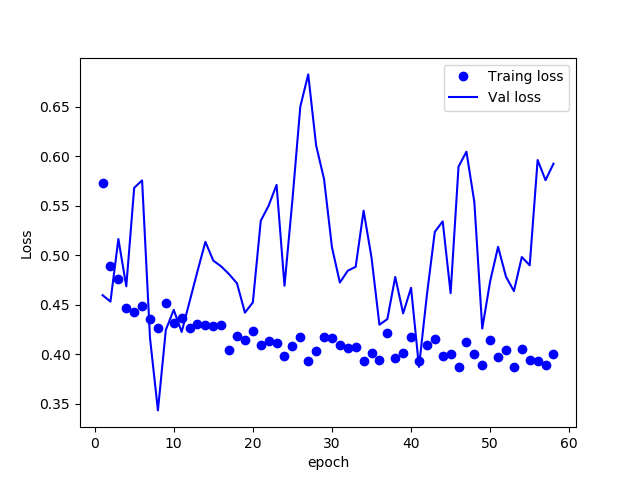

In [27]:
historyDict=history.history

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

%matplotlib notebook
epo = range(1, len(acc)+1)
plt.plot(epo, loss, 'bo', label="Traing loss")
plt.plot(epo, val_loss, 'b', label="Val loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


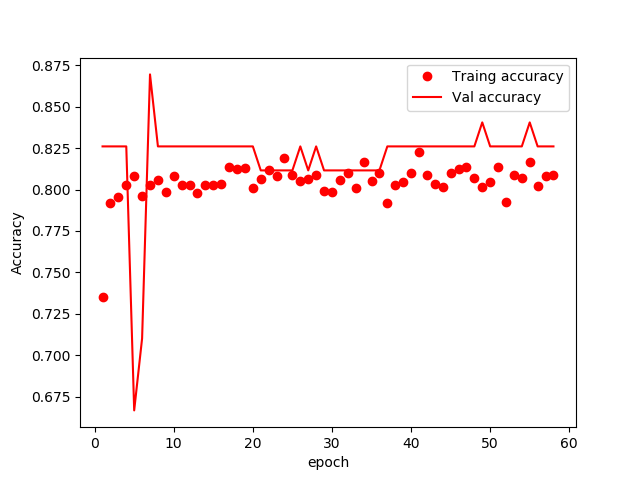

In [28]:
%matplotlib notebook

plt.plot(epo, acc, 'ro', label="Traing accuracy")
plt.plot(epo, val_acc, 'r', label="Val accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [29]:
scores = model.evaluate_generator(test_generator)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

scores = model.evaluate_generator(test_generator)
print("%s: %.2f%%" %(model.metrics_names[0], scores[0]*100))


/home/lab03/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


accuracy: 82.55%
loss: 53.52%


In [30]:
from tensorflow.keras.models import load_model

model = load_model('root.h5')

In [47]:
# 테스트 데이터 준비 
filenames = os.listdir('test_img/test_img/')

test_df=pd.DataFrame( {"filename":filenames} )      
test_df

nbsamples=test_df.shape[0]

In [48]:
test_df.sort_values(by=['filename'], axis=0, inplace=True)

In [49]:
test_df

filename
9               black_all.png
23            black_fruit.png
21  black_fruitbranchroot.png
30                 branch.png
1                 branch2.png
39             branchknot.png
0             branchroot3.png
32            draw_branch.jpg
19        draw_branchroot.jpg
20             draw_fruit.jpg
10   draw_fruitbranchroot.jpg
33              draw_knot.jpg
37             draw_knot2.jpg
16             draw_knot3.jpg
2             draw_photo1.png
36            draw_photo2.png
13            draw_photo3.png
26            draw_photo4.png
14            draw_photo5.png
24            draw_photo6.png
35                  fruit.png
8                  fruit2.png
18        fruitbranchroot.png
31                   knot.png
17                  knot2.png
38         knotbranchroot.png
22               knotroot.png
25                 leaves.png
6              onlybranch.png
4                  photo1.png
29                 photo2.png
34                 photo3.png
7                  photo4.png
11                 photo5.png
5                  photo6.png
15            photo_fruit.jpg
3          photo_knotroot.jpg
27                   root.png
28             rootbranch.png
12            rootbranch2.png

In [50]:
test_datagen=ImageDataGenerator(rescale=1./255)
# 테스트 이미지니까, 사진 그대로 씀
test_generator=test_datagen.flow_from_dataframe(
    test_df,
    "test_img/test_img/",
    x_col= "filename",
    y_col= None,
    target_size = IMAGE_SIZE,
    class_mode = None,
    batch_size = batch_size,
    shuffle = False)

Found 40 validated image filenames.


In [53]:
# 3. 예측 
predict=model.predict_generator(test_generator)                                
test_df['category']=np.argmax(predict, axis=1)

/home/lab03/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [54]:
test_df['category']=test_df['category'].replace({0:'others',1:"fruit"})
ex_df=test_df.sample(10).reset_index(drop=True)
ex_df

filename category
0              knotroot.png   others
1                photo3.png   others
2           draw_photo3.png   others
3        knotbranchroot.png   others
4  draw_fruitbranchroot.jpg   others
5           draw_branch.jpg   others
6           draw_photo4.png   others
7            draw_knot2.jpg   others
8            draw_knot3.jpg   others
9       draw_branchroot.jpg   others

In [56]:
ex_generator = test_datagen.flow_from_dataframe(
                    ex_df,
                    "test_img/test_img/",
                    x_col = "filename",
                    y_col = None,
                    target_size = IMAGE_SIZE,
                    class_mode = None)

Found 10 validated image filenames.


In [57]:
test_sample=list(ex_df.filename)

sample = ""
for test in test_sample:
    sample += test

['black_all.png']


<IPython.core.display.Javascript object>


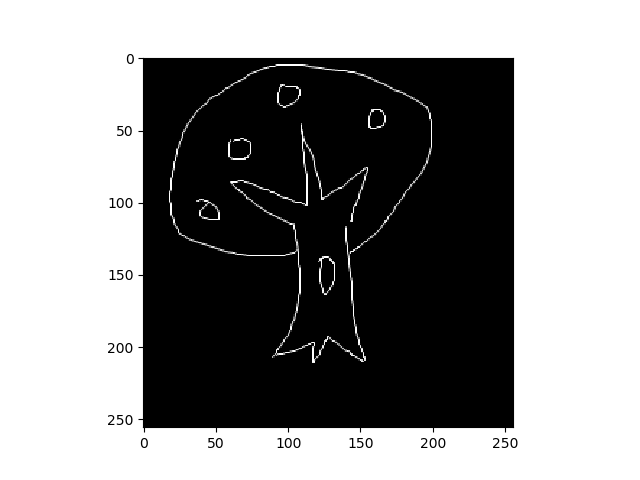

['black_fruit.png']


<IPython.core.display.Javascript object>


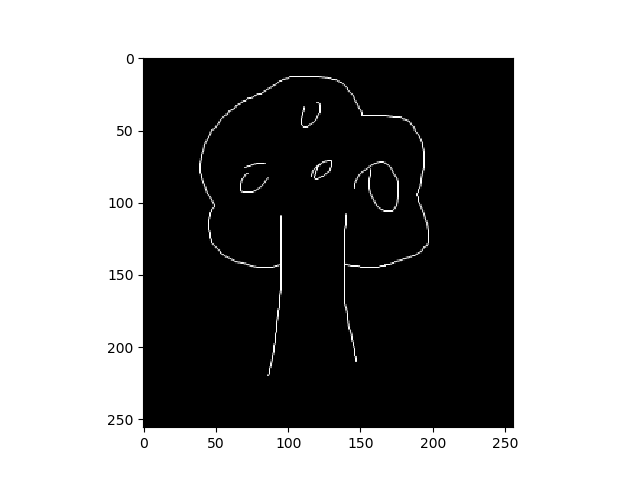

['black_fruitbranchroot.png']


<IPython.core.display.Javascript object>


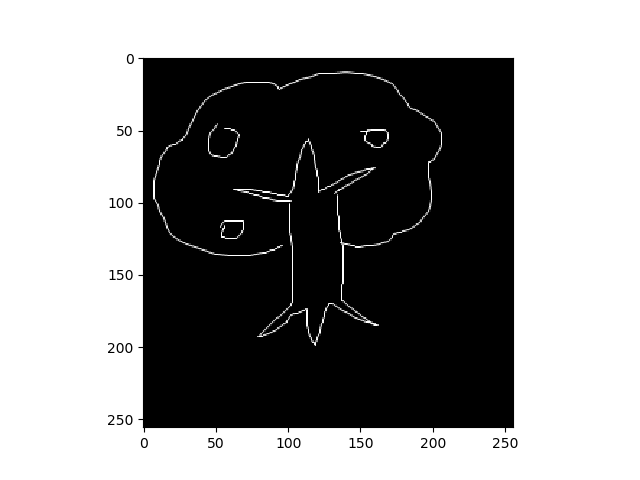

['branch.png']


<IPython.core.display.Javascript object>


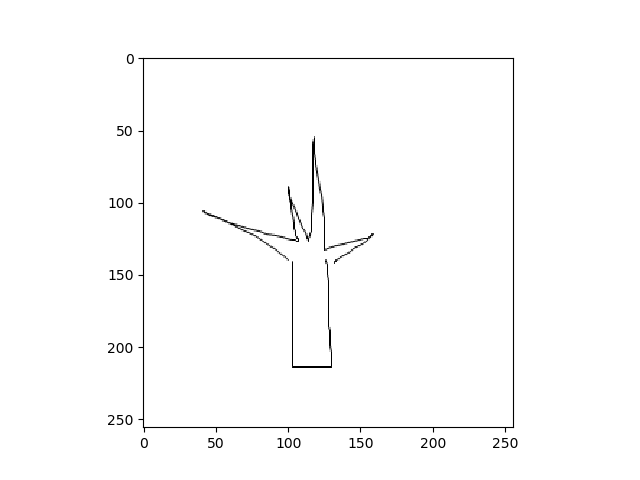

['branch2.png']


<IPython.core.display.Javascript object>


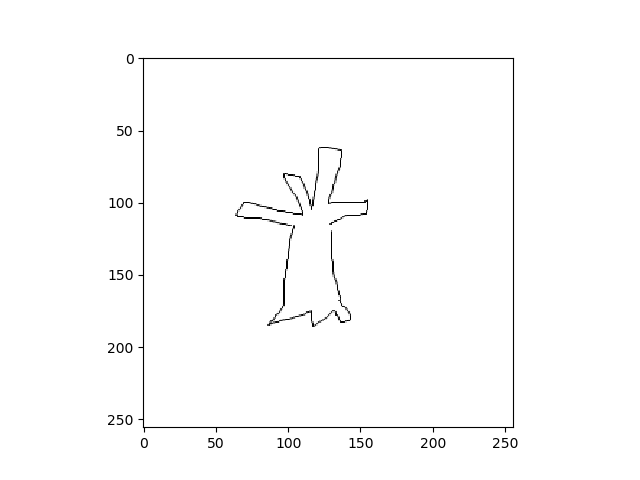

['branchknot.png']


<IPython.core.display.Javascript object>


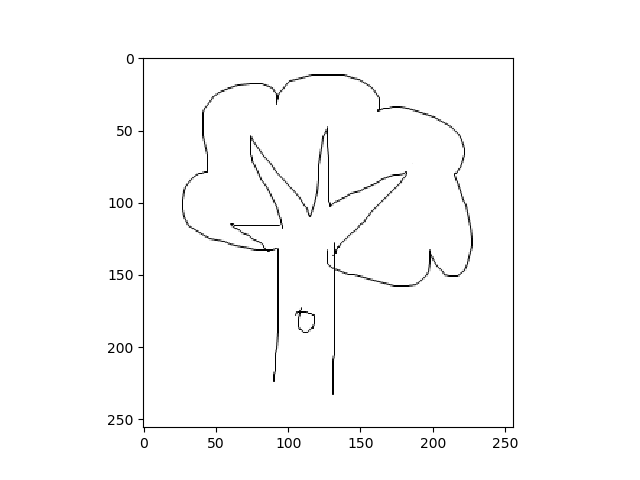

['branchroot3.png']


<IPython.core.display.Javascript object>


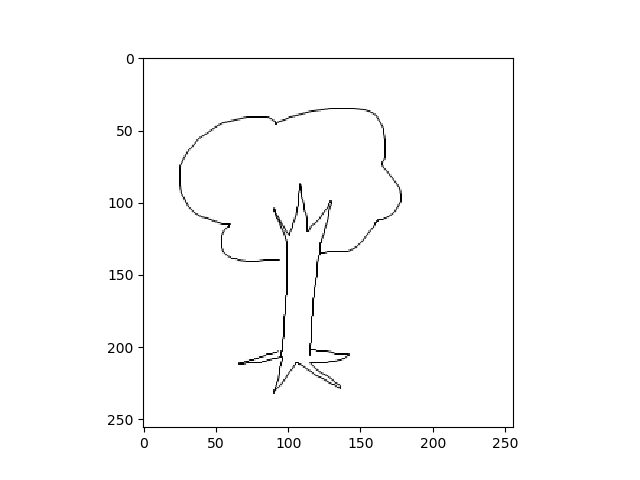

['draw_branch.jpg']


<IPython.core.display.Javascript object>


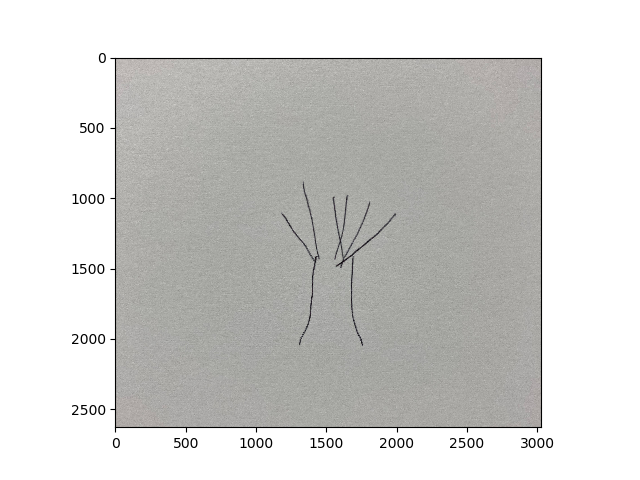

['draw_branchroot.jpg']


<IPython.core.display.Javascript object>


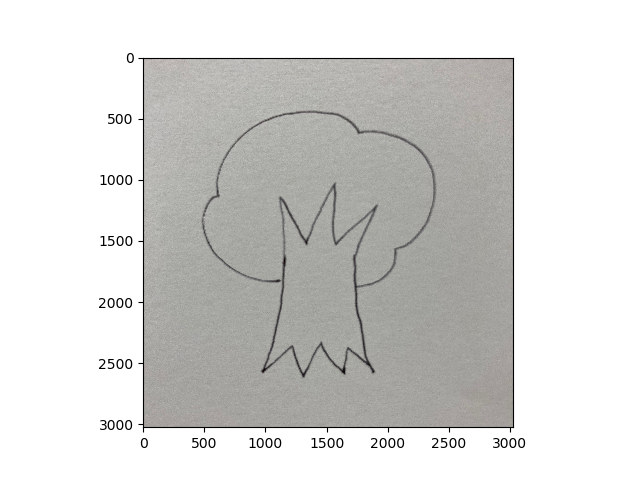

['draw_fruit.jpg']


<IPython.core.display.Javascript object>


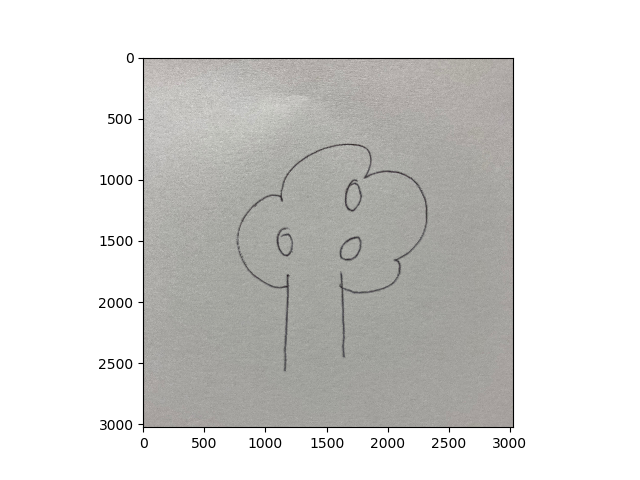

['draw_fruitbranchroot.jpg']


<IPython.core.display.Javascript object>


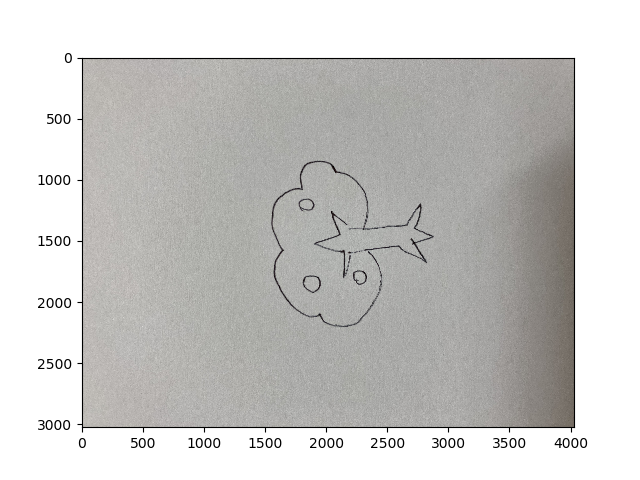

['draw_knot.jpg']


<IPython.core.display.Javascript object>


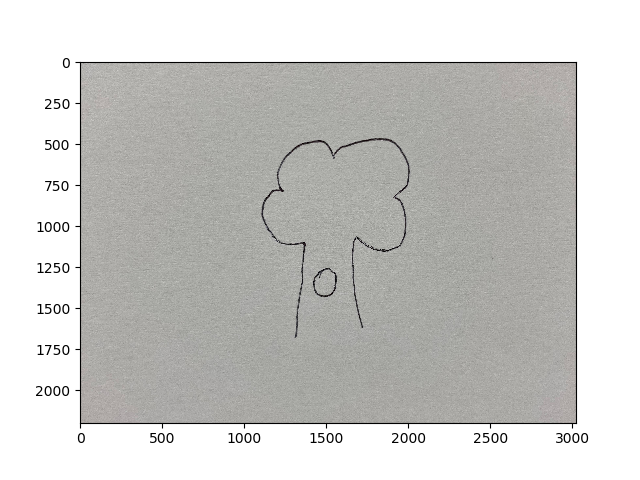

['draw_knot2.jpg']


<IPython.core.display.Javascript object>


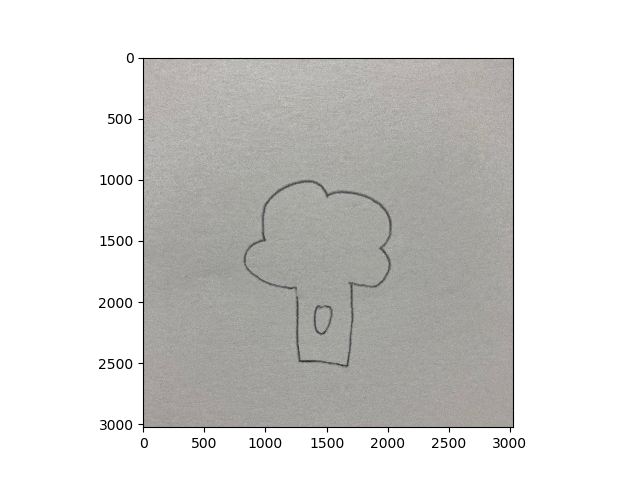

['draw_knot3.jpg']


<IPython.core.display.Javascript object>


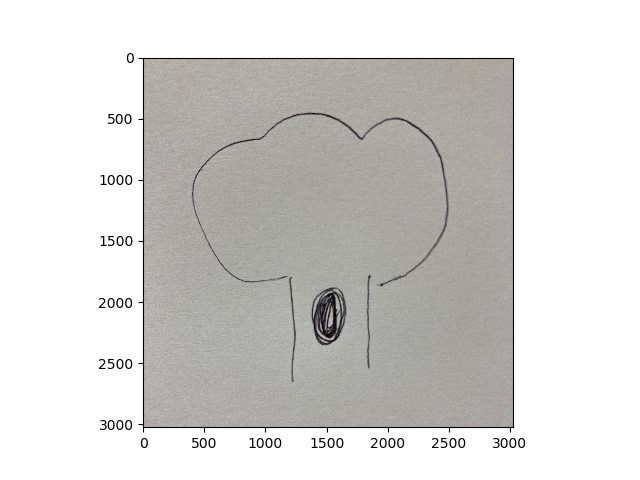

['draw_photo1.png']


<IPython.core.display.Javascript object>


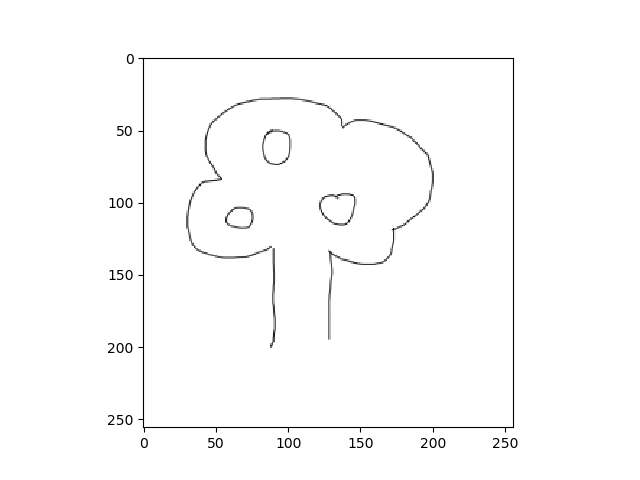

['draw_photo2.png']


<IPython.core.display.Javascript object>


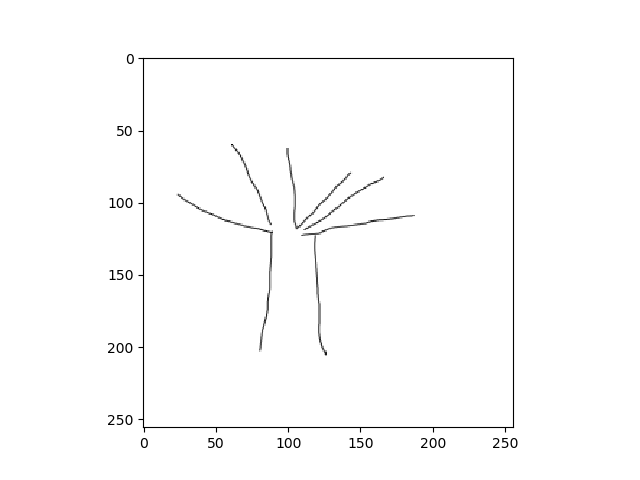

['draw_photo3.png']


<IPython.core.display.Javascript object>


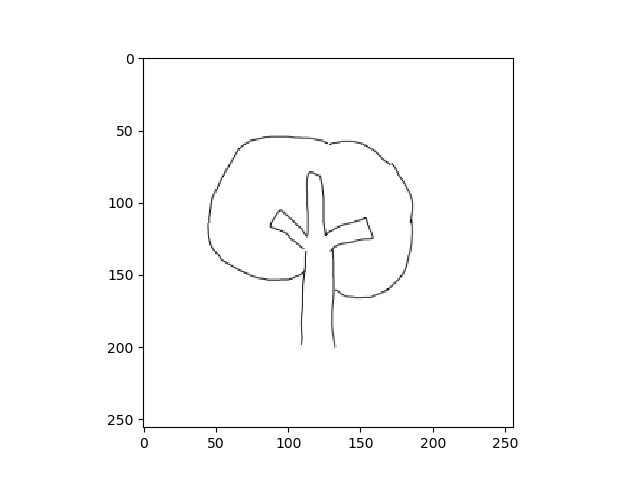

['draw_photo4.png']


<IPython.core.display.Javascript object>


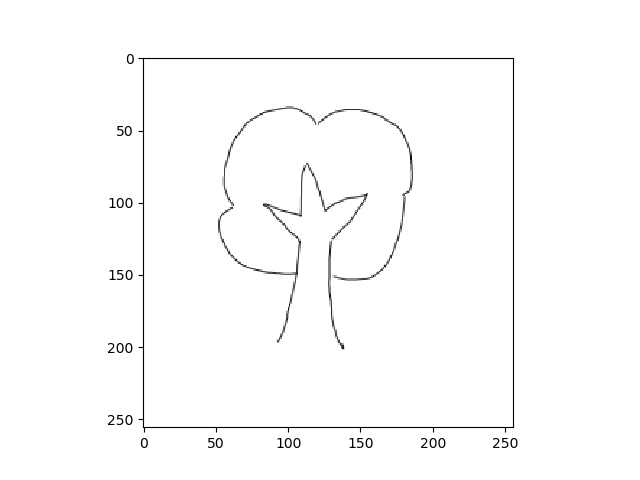

['draw_photo5.png']


<IPython.core.display.Javascript object>


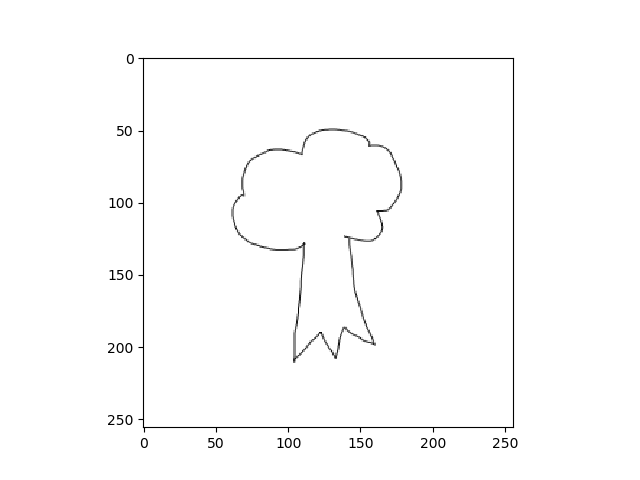

['draw_photo6.png']


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


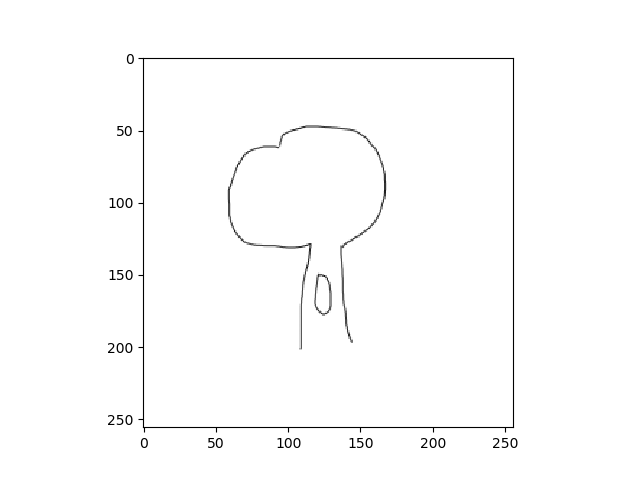

['fruit.png']


<IPython.core.display.Javascript object>


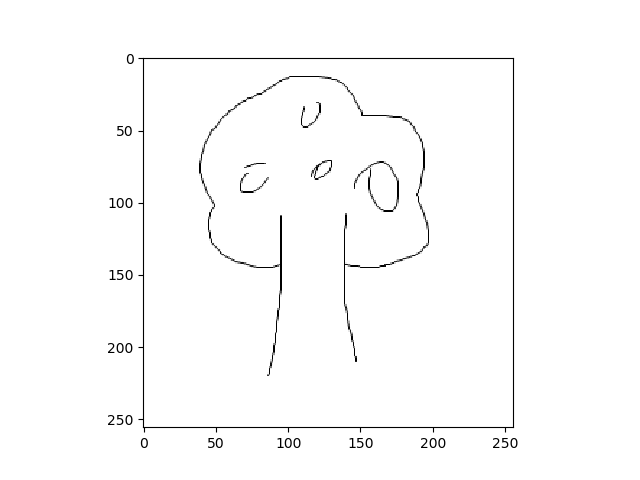

['fruit2.png']


<IPython.core.display.Javascript object>


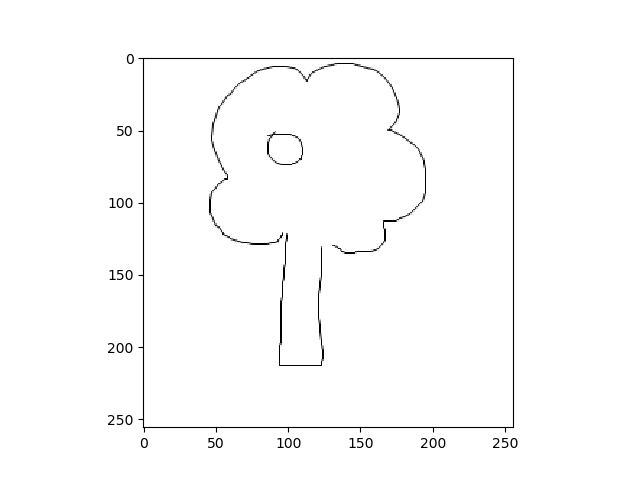

['fruitbranchroot.png']


<IPython.core.display.Javascript object>


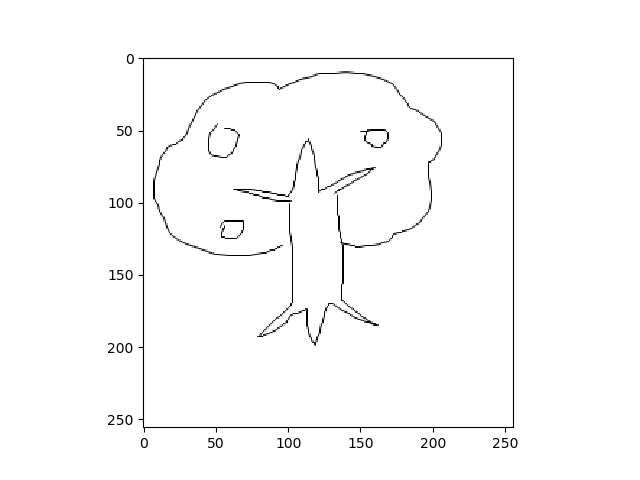

['knot.png']


<IPython.core.display.Javascript object>


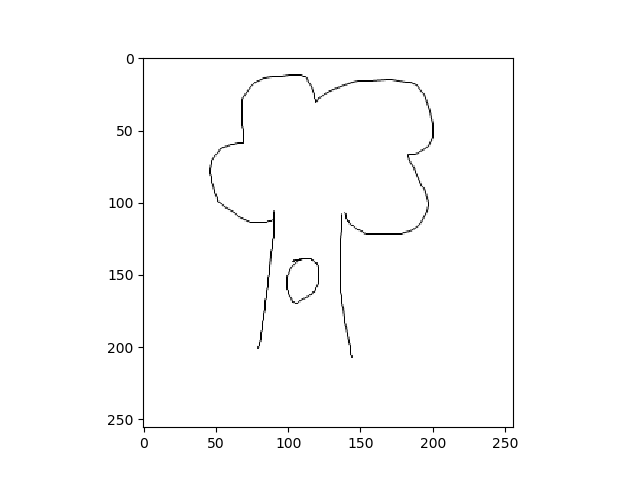

['knot2.png']


<IPython.core.display.Javascript object>


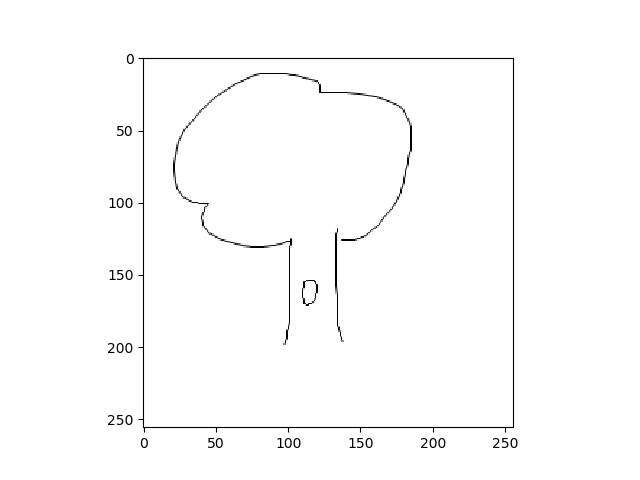

['knotbranchroot.png']


<IPython.core.display.Javascript object>


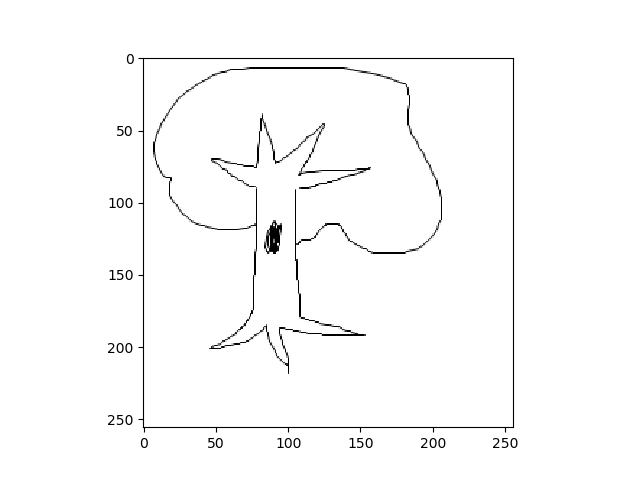

['knotroot.png']


<IPython.core.display.Javascript object>


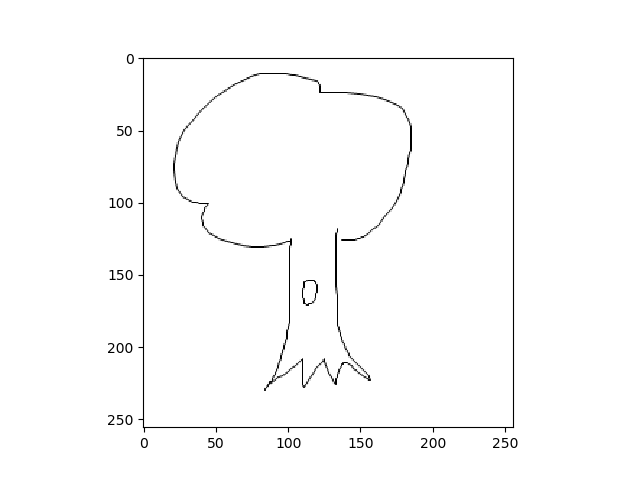

['leaves.png']


<IPython.core.display.Javascript object>


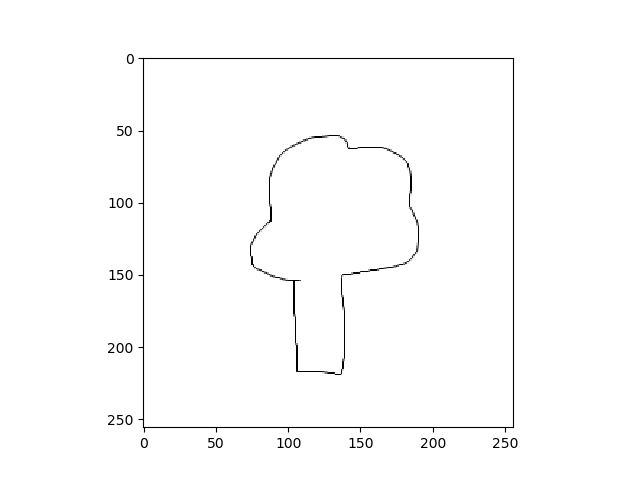

['onlybranch.png']


<IPython.core.display.Javascript object>


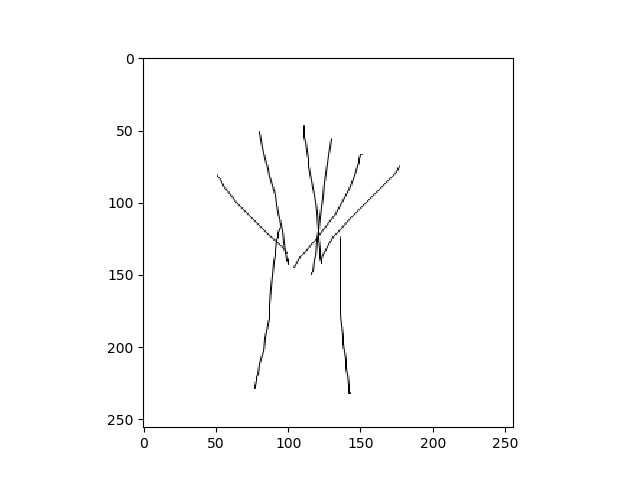

['photo1.png']


<IPython.core.display.Javascript object>


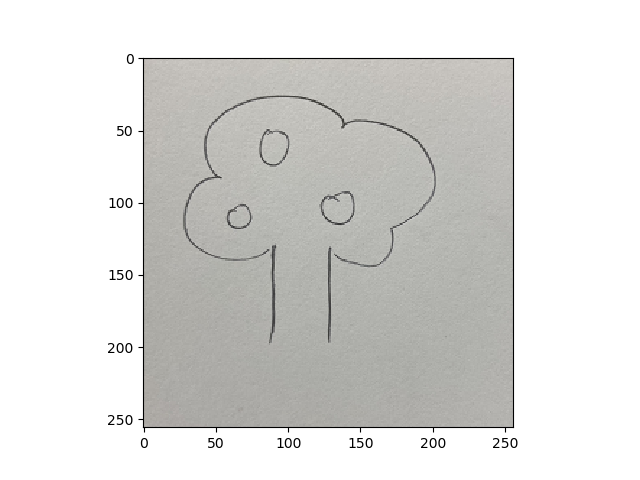

['photo2.png']


<IPython.core.display.Javascript object>


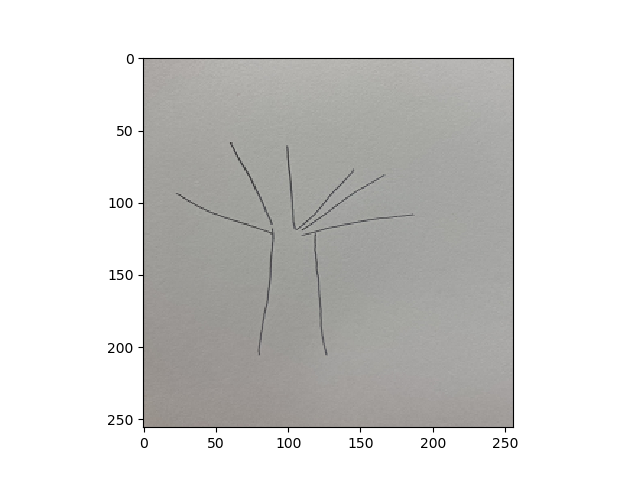

['photo3.png']


<IPython.core.display.Javascript object>


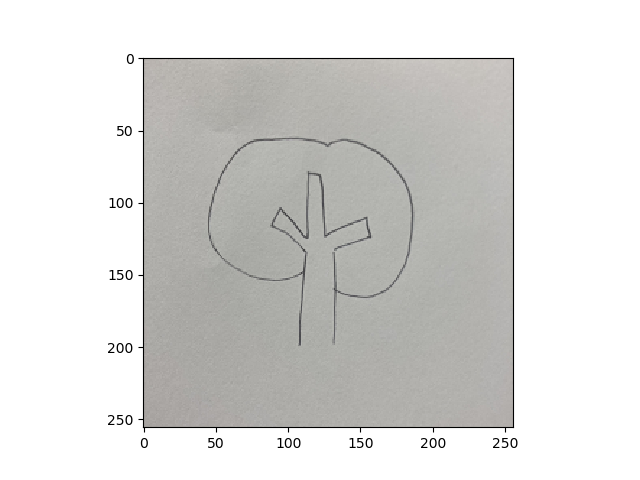

['photo4.png']


<IPython.core.display.Javascript object>


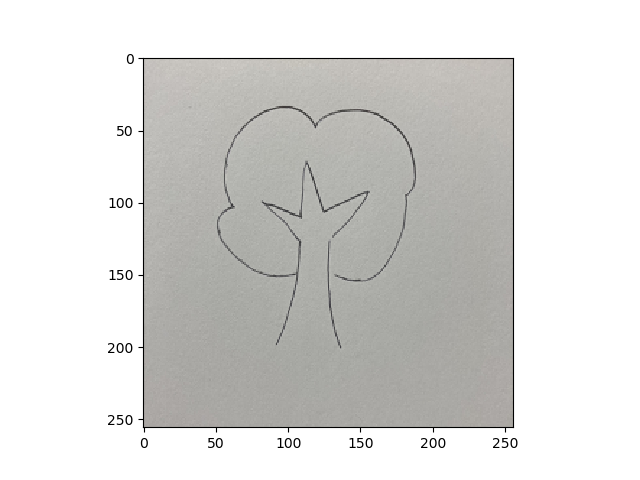

['photo5.png']


<IPython.core.display.Javascript object>


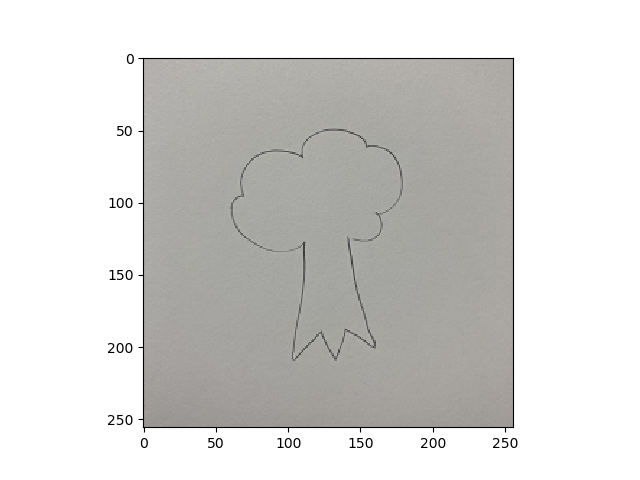

['photo6.png']


<IPython.core.display.Javascript object>


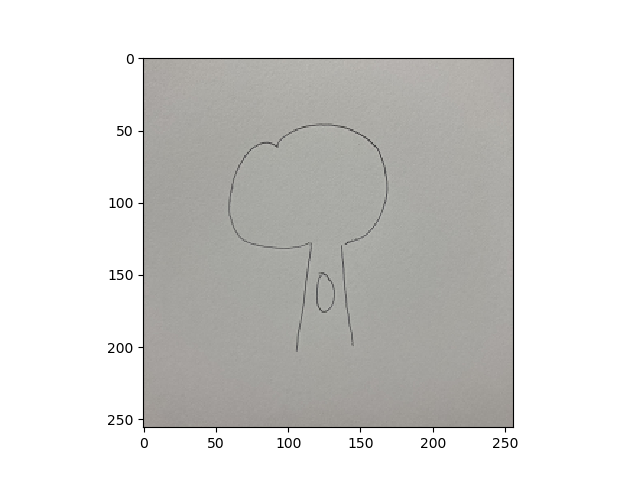

['photo_fruit.jpg']


<IPython.core.display.Javascript object>


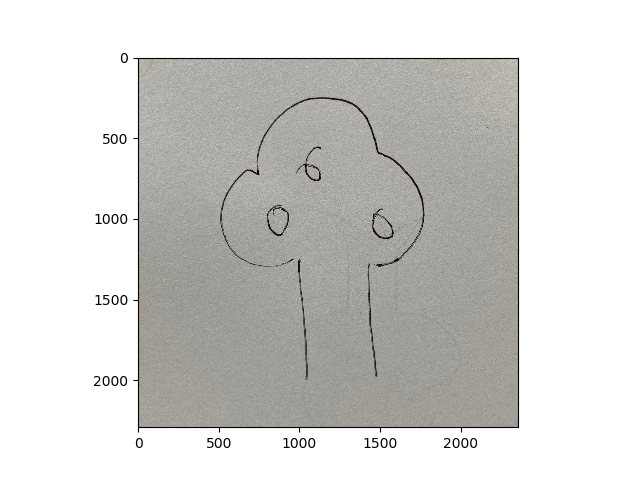

['photo_knotroot.jpg']


<IPython.core.display.Javascript object>


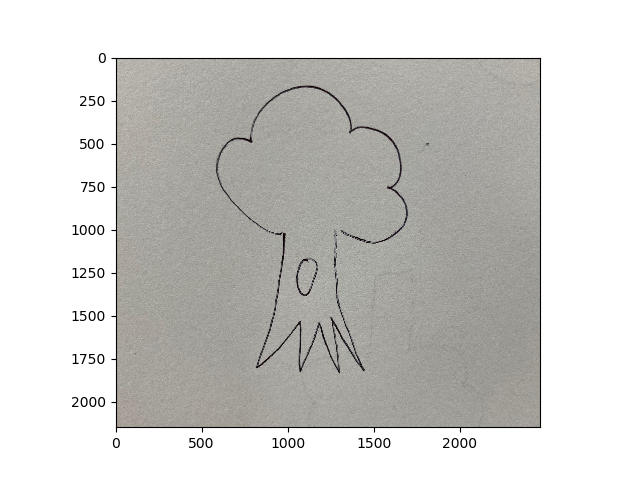

['root.png']


<IPython.core.display.Javascript object>


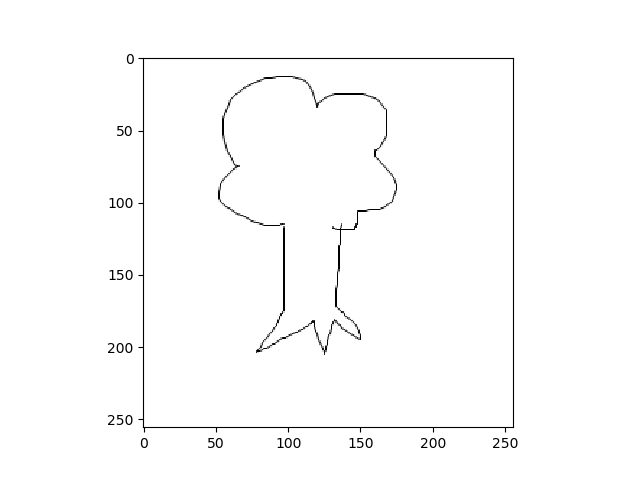

['rootbranch.png']


<IPython.core.display.Javascript object>


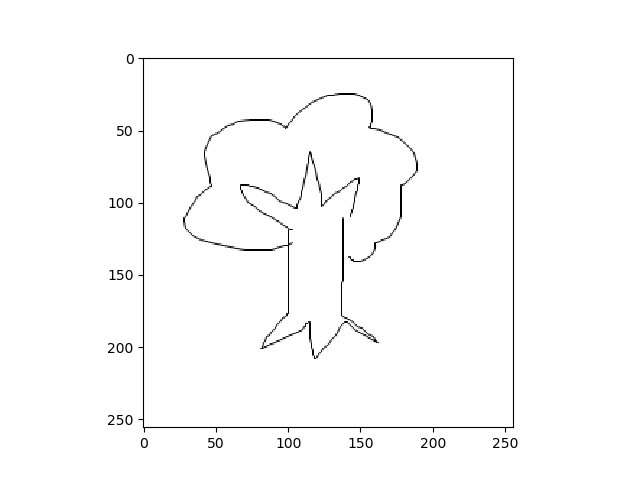

['rootbranch2.png']


<IPython.core.display.Javascript object>


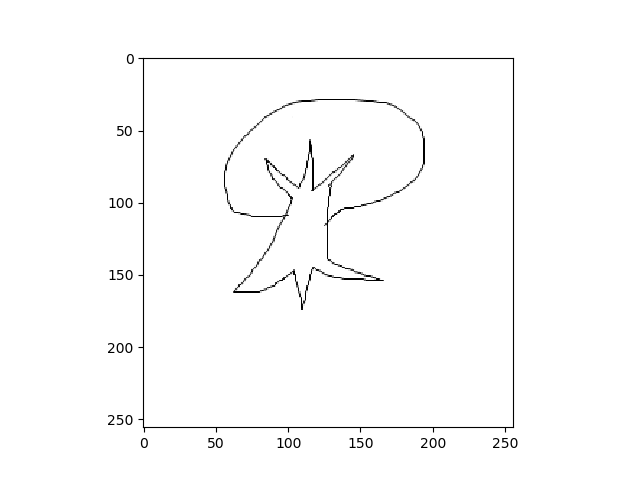

In [65]:
for i in test_df['filename']:
    print([i])
    image = load_img("test_img/test_img/" + i)
    plt.figure()
    plt.imshow(image)

    plt.show()